In [40]:
import torch 
from torchinfo import summary
import numpy as np
from opt_einsum_torch import EinsumPlanner
from torch.utils.data import DataLoader
import torch.nn as nn
from torchinfo import summary
from torchvision.datasets import MNIST
from torchvision import transforms
import torch.distributions as D
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [2]:
torch.cuda.is_available()

True

In [3]:
device = torch.device('cuda:0')

In [4]:
transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize(mean=0.1307,std=0.3081)])
dataset=MNIST(root='./root',download=True,train=True,transform=transform)
testset=MNIST(root='./root',download=True,train=False,transform=transform)

In [5]:
dataset.data.shape

torch.Size([60000, 28, 28])

In [6]:
dataset.data[0].shape

torch.Size([28, 28])

In [7]:
dataset.data = dataset.data.unsqueeze(1).to(device)

In [8]:
testset.data = testset.data.unsqueeze(1).to(device)

In [9]:
class Encoder(nn.Module):
    def __init__(self,ldim):
        super().__init__() 
        self.layers = nn.Sequential(
            nn.Conv2d(1, 32, 4, stride=3),
            nn.ReLU(),
            nn.Flatten(1,-1),
             nn.Linear(2592,ldim)
        )
    def forward(self,x):
        x = x.float()
        return self.layers(x)

In [10]:
class Decoder(nn.Module):
    def __init__(self,ldim):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(ldim,2592),
            nn.Unflatten(1,(32,9,9)),
            nn.ConvTranspose2d(32,1,4,stride=3),
            nn.ReLU()
        )
        
    def forward(self,x):
        x = x.float()
        return self.layers(x)

In [11]:
class AutoEncoder(nn.Module):
    def __init__(self,ldim):
        super().__init__()
        self.encoder = Encoder(ldim)
        self.decoder = Decoder(ldim)
        
    def forward(self,x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x.float()

## Autoencoder with 32 latent dimensions

In [12]:
# Latent Dimensions=32
model1 = AutoEncoder(32).to(device)
X_train = dataset.data.float()
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model1.parameters(),lr=0.02)
epochs=50
for epoch in tqdm(range(epochs)):
    model1.train()
    X_pred = model1(X_train)
    loss = loss_fn(X_pred,X_train)
    if epoch+1%5==0:
        print(f"Loss: {loss} at Epoch {epoch+1}")
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()    

  0%|          | 0/50 [00:00<?, ?it/s]

## Training Data Reconstruction for Autoencoder with 32 latent dimensions

In [13]:
train_recons = torch.zeros(10,28,28)
with torch.no_grad():
    for i in range(10):
         train_recons[i] = model1(dataset.data[i].unsqueeze(0))

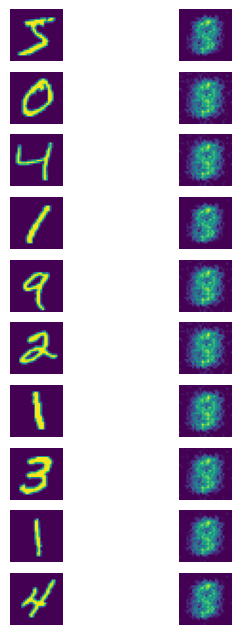

In [14]:
j=1
plt.figure(figsize=(4,8))
for i in range(10):
    plt.subplot(10,2,j)
    plt.axis('off')
    plt.imshow(dataset.data[i].squeeze().cpu().numpy())
    
    j+=1
    
    plt.subplot(10,2,j)
    plt.axis('off')
    plt.imshow(train_recons[i].cpu().numpy())
    
    j+=1

## Test Data Reconstruction for Autoencoder with 32 latent dimensions

In [15]:
test_recons = torch.zeros(10,28,28)
with torch.no_grad():
    for i in range(10):
         test_recons[i] = model1(testset.data[i].unsqueeze(0))

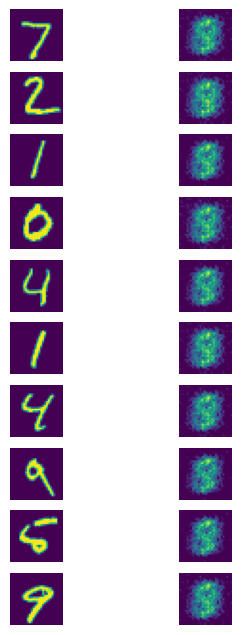

In [16]:
j=1
plt.figure(figsize=(4,8))
for i in range(10):
    plt.subplot(10,2,j)
    plt.axis('off')
    plt.imshow(testset.data[i].squeeze().cpu().numpy())
    
    j+=1
    
    plt.subplot(10,2,j)
    plt.axis('off')
    plt.imshow(test_recons[i].cpu().numpy())
    
    j+=1

## Autoencoder with 64 Latent Dimensions

In [17]:
# Latent Dimensions=64
model2 = AutoEncoder(64).to(device)
X_train = dataset.data.float()
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model1.parameters(),lr=0.02)
epochs=50
for epoch in tqdm(range(epochs)):
    model2.train()
    X_pred = model2(X_train)
    loss = loss_fn(X_pred,X_train)
    if epoch+1%5==0:
        print(f"Loss: {loss} at Epoch {epoch+1}")
    optimizer.zero_grad()
    loss.backward()
    optimizer.step() 

  0%|          | 0/50 [00:00<?, ?it/s]

## Training Data Reconstruction for Autoencoder with 64 latent dimensions

In [18]:
train_recons = torch.zeros(10,28,28)
model2.eval()
with torch.no_grad():
    for i in range(10):
         train_recons[i] = model2(dataset.data[i].unsqueeze(0))

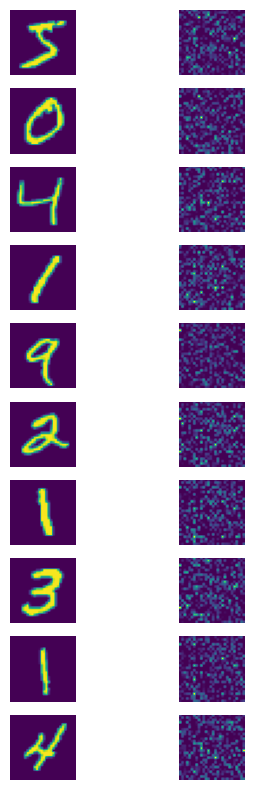

In [19]:
j=1
plt.figure(figsize=(4,10))
for i in range(10):
    plt.subplot(10,2,j)
    plt.axis('off')
    plt.imshow(dataset.data[i].squeeze().cpu().numpy())
    
    j+=1
    
    plt.subplot(10,2,j)
    plt.axis('off')
    plt.imshow(train_recons[i].cpu().numpy())
    
    j+=1

## Test Data Reconstruction for Autoencoder with 64 latent dimensions

In [20]:
test_recons = torch.zeros(10,28,28)
with torch.no_grad():
    for i in range(10):
         test_recons[i] = model2(testset.data[i].unsqueeze(0))

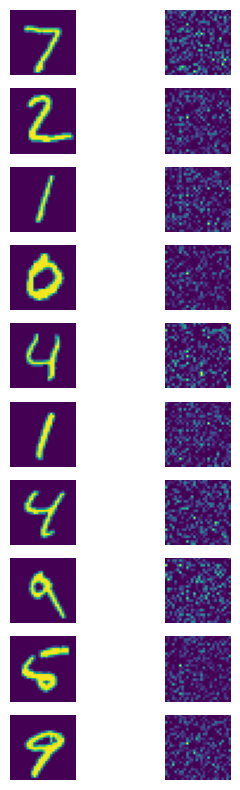

In [21]:
j=1
plt.figure(figsize=(4,10))
for i in range(10):
    plt.subplot(10,2,j)
    plt.axis('off')
    plt.imshow(testset.data[i].squeeze().cpu().numpy())
    
    j+=1
    
    plt.subplot(10,2,j)
    plt.axis('off')
    plt.imshow(test_recons[i].cpu().numpy())
    
    j+=1
plt.subplots_adjust(wspace=0)

### Reconstruction on line joining 2 datasamples

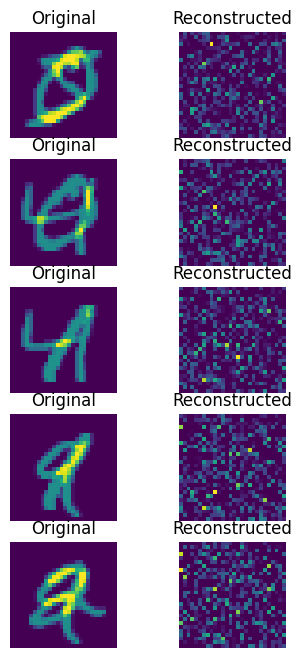

In [22]:
alpha=0.5
j=1
model2.eval()
plt.figure(figsize=(4,8))
for i in range(5):
    plt.subplot(5,2,j)
    plt.axis('off')
    plt.title('Original')
    plt.imshow((alpha*dataset.data[i]+(1-alpha)*dataset.data[i+1]).squeeze().cpu().numpy())
    
    j+=1
    
    plt.subplot(5,2,j)
    plt.axis('off')
    plt.title('Reconstructed')
    plt.imshow(model2(alpha*dataset.data[i].unsqueeze(0)+(1-alpha)*dataset.data[i+1].unsqueeze(0)).detach().squeeze().cpu().numpy())
    
    j+=1

## Variational AutoEncoder

In [28]:
class VariationalEncoder(nn.Module):
    def __init__(self):
        super().__init__() 
        self.layers = nn.Sequential(
            nn.Conv2d(1, 32, 4, stride=3),
            nn.ReLU(),
            nn.Flatten(1,-1),
        )
        self.mu = nn.Linear(2592,16)
        self.sigma = nn.Linear(2592,16)
    
    def forward(self,x):
        x = x.float()
        x = self.layers(x)
        epsilon = torch.normal(torch.zeros(16),torch.ones(16)).cuda(device)
        return self.mu(x)+self.sigma(x)*epsilon,self.mu(x),self.sigma(x)

In [29]:
class VariationalDecoder(nn.Module):
    def __init__(self):
        super().__init__() 
        self.layers = nn.Sequential(
            nn.Linear(16,2592),
            nn.Unflatten(1,(32,9,9)),
            nn.ConvTranspose2d(32,1,4,stride=3),
            nn.ReLU()
        )
        
    def forward(self,x):
        return self.layers(x)

In [30]:
class VAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.vencoder = VariationalEncoder().to(device)
        self.vdecoder = VariationalDecoder().to(device)
        
    def forward(self,x):
        x = x.float()
        x,mu,sigma = self.vencoder(x)
        x = self.vdecoder(x)
        kl = (mu**2 + sigma**2 - torch.log(sigma) - 0.5).sum()
        return x,kl

In [31]:
train_loader = torch.utils.data.DataLoader(
    dataset.data.to('cpu'), batch_size=512, shuffle=True, num_workers=4, pin_memory=False
)

$\mathbb{KL}\left( \mathcal{N}(\mu, \sigma) \parallel \mathcal{N}(0, 1) \right) = \sum_{x \in X} \left( \sigma^2 + \mu^2 - \log \sigma - \frac{1}{2} \right)$

In [32]:
model45 = VAE().to(device)
loss_fn1 = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model45.parameters(),lr=0.02)
epochs=50
for epoch in tqdm(range(epochs)):
    for data in train_loader:
        model45.train()
        X_pred,kl = model45(data.to(device))
        loss1 = loss_fn1(X_pred,data.float().to(device))
        loss = loss1+kl
        if epoch+1%5==0:
            print(f"Loss: {loss} at Epoch {epoch+1}")
        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()

  0%|          | 0/50 [00:00<?, ?it/s]

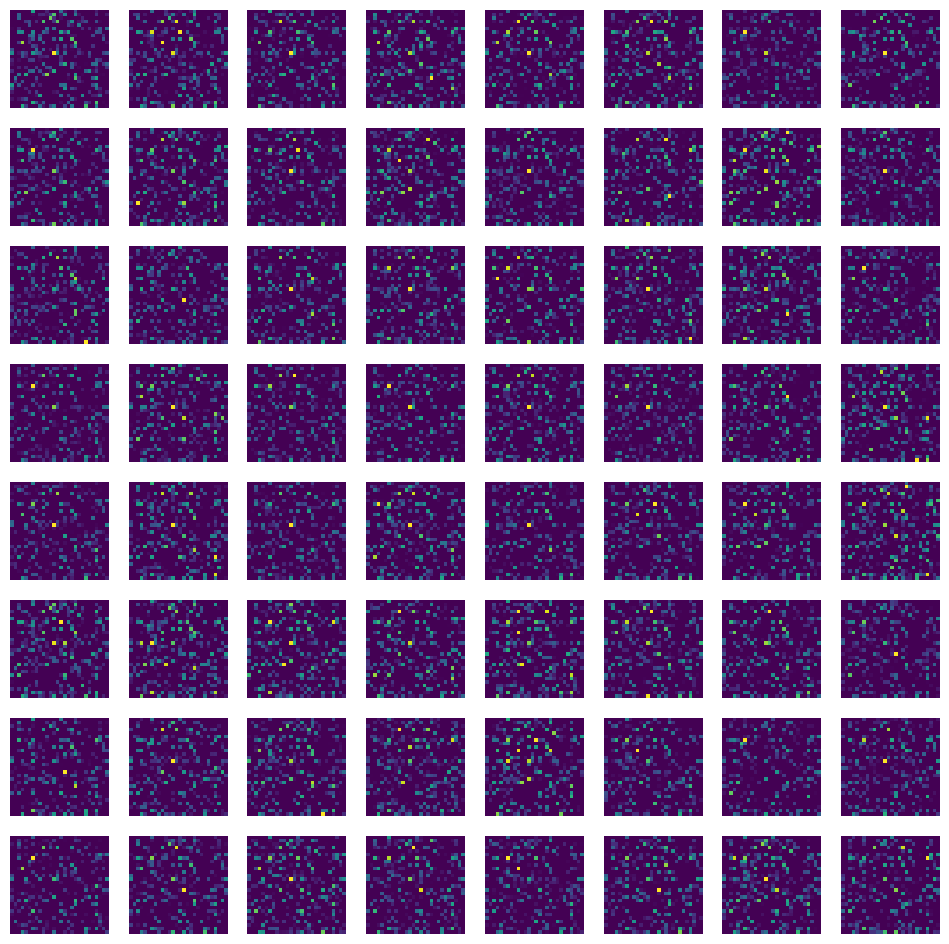

In [33]:
plt.figure(figsize=(12,12))

model45.eval()
with torch.inference_mode():
    for j in range(64):
            plt.subplot(8,8,j+1)
            plt.axis('off')
            output = model45.vdecoder(torch.rand(1,16).to(device)).cpu().numpy()
            plt.imshow(output.squeeze())

## Self-Attention

In [34]:
#Cifar10 Preprocessing
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [35]:
def parse_record(record):
    depth_major = record.reshape((3, 32, 32))
    image = np.transpose(depth_major,[1,2,0])
    return image

In [36]:
data = unpickle('cifar-10-python/cifar-10-batches-py/data_batch_3')
finaldata = []
for i in range(data[b'data'].shape[0]):
    finaldata.append(parse_record(data[b'data'][i]))
finaldata=torch.Tensor(np.transpose(np.array(finaldata),(0,3,1,2))).to(device)

In [37]:
finaldata.shape

torch.Size([10000, 3, 32, 32])

In [38]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
        nn.Conv2d(3,16,3),
        nn.MaxPool2d(3),
        nn.ReLU(),
        nn.Flatten(2,-1)
        )
        
    def forward(self,x):
        return self.layers(x)

In [41]:
model23 = CNN().to(device)
Xenc = model23(finaldata)

In [42]:

summary(model23,(10000,3,32,32))

Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      [10000, 16, 100]          --
├─Sequential: 1-1                        [10000, 16, 100]          --
│    └─Conv2d: 2-1                       [10000, 16, 30, 30]       448
│    └─MaxPool2d: 2-2                    [10000, 16, 10, 10]       --
│    └─ReLU: 2-3                         [10000, 16, 10, 10]       --
│    └─Flatten: 2-4                      [10000, 16, 100]          --
Total params: 448
Trainable params: 448
Non-trainable params: 0
Total mult-adds (G): 4.03
Input size (MB): 122.88
Forward/backward pass size (MB): 1152.00
Params size (MB): 0.00
Estimated Total Size (MB): 1274.88

In [43]:
Xenc.shape

torch.Size([10000, 16, 100])

In [44]:
class SelfAttention(nn.Module):
    def __init__(self):
        super().__init__()
        self.qweights = nn.Parameter(torch.randn(100,4))
        self.kweights = nn.Parameter(torch.randn(100,4))
        self.vweights = nn.Parameter(torch.randn(100,4))
        self.softmax = nn.Softmax(dim=1)
        
        
    def forward(self,x):
        queries = x@self.qweights
        values = x@self.vweights
        keys = x@self.kweights
        scores = torch.zeros(x.shape[0],x.shape[1],x.shape[1])
        for i in range(x.shape[0]):
            scores[i]=queries[i].squeeze()@keys[i].T.squeeze()/2
        scores = self.softmax(scores.squeeze())
        ee = EinsumPlanner(device, cuda_mem_limit=0.9)
        sv = ee.einsum('ijk,ikm->ijkm',scores,values)
        sv = torch.sum(sv,dim=-1)
        return sv

In [45]:
sa = SelfAttention().to(device)
yh = sa(Xenc)

In [46]:
yh.shape

torch.Size([10000, 16, 16])